<a href="https://colab.research.google.com/github/dirksen/ml-playground/blob/main/Digging_For_Good_Debates_with_Zero_Shot_Stance_Detection_from_%F0%9F%A4%97_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debate Mining

When watching Youtube vidoes on hot-button topics, I would often deep dive into the comments section to look for good arguments and counter arguments. Youtube organize the comments section into two levels: top level comments that address to the video, and replies to those comments. Often I found good debates among these reply threads that brought fresh angles and insights. Unfortunately, Youtube's UI make it very difficult to dig up good debates:
1. Youtube doesn't sort comments by the number of replies. I have to scroll and skip a lot of comments of zero replies just to access the reply threads.
2. Not all threads present good debates. Many of them are one-sided, like mini-echo-chambers. It's time consuming to read tens of replies only to find out there isn't much debate going in the thread.

This notebook attempts to mine good debates from the video comment threads, by using Youtube API to scrape top N most replied comment threads, and then use HuggingFace's ML model to rank them. It will render the threads at the end for easy reading.

## Ranking Strategy

The goal is to score each thread that reflects how good a debate the thread is. Based on observations, I found two indicators for a good debate:

1. Debate is like a tennis game: each side takes turn to present their arguments. The more rounds of back and forth, the more exciting the debate is.
2. A good debate should also be balanced, i.e. the number of pro arguments and con arguments should be close. A big delta between the two indicates the debate is one-sided.

Obviously, both indicators depend on the classification of each reply as either pro argument or con argument. This is stance detection.

## Stance Detection using the 🤗 Hugging Face ML Platform

[Hugging Face](https://huggingface.co/) is an open source data science and machine learning platform, like a GitHub for AI. It hosts many AI models contributed by others. In this exercise, I will use the [DeBERTa-Large model](https://huggingface.co/microsoft/deberta-large) for stance detection. Given a claim and a comment to that claim, stance detection is to figure out if the comment is supportive, against, or neutral to the claim. E.g. giving the claim `the earth is flat`, comment `yes it is` is supportive in stance.

Let's see how it works in actions:

In [2]:
%%capture
!pip install torch pandas google-api-python-client transformers ipdb

import ipdb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import googleapiclient.discovery
from transformers import pipeline


Let's initiate a zero-shot classifier:

In [3]:
classifier = pipeline("zero-shot-classification", model='MoritzLaurer/deberta-v3-large-zeroshot-v1', device = 'cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Here defines a function that takes one claim, and a list of comments, and then returns a list of stance corresponding to each comment (and the confidence for each outcome):

In [4]:
def detect_stance(claim, list_of_comments, classifier=classifier):
  # Like ChatGPT, it works by prompting
  prompt = 'The author of this comment {} the claim: `%s`.' % claim
  # lables for 3 possible stance outcomes
  labels = ['supports', 'opposes', 'does not express an opinion about']
  res = classifier(list_of_comments, labels, hypothesis_template = prompt, multi_item = False)
  # per https://github.com/huggingface/transformers/issues/22387, reset the call_count to inhibit a warning
  classifier.call_count = 0
  df = pd.DataFrame()
  df['comments'] = list_of_comments
  df['stance'] = [outcome['labels'][0] for outcome in res]
  df['claim'] = [claim] * len(list_of_comments)
  return df

Let's run the function over one cliam and a list of comments to that claim:

In [5]:
claim = 'The earth is flat.'
comments = [
           'Yes, it is flat.',
           'The earth is actually round.',
           'Pluto is not a planet.'
           ]
detect_stance(claim, comments)


,comments,stance,claim
0,"Yes, it is flat.",supports,The earth is flat.
1,The earth is actually round.,opposes,The earth is flat.
2,Pluto is not a planet.,does not express an opinion about,The earth is flat.


## Scraping Comment Threads
We need API keys to access Youtube API:

In [6]:
from google.colab import userdata
DEVELOPER_KEY = userdata.get('ytDevKey')

To speed up development iteration, cache the scraping results using `Memory` and `lru_cache`:

In [7]:
from joblib import Memory
from functools import lru_cache

memory = Memory('cache/')

`TARGET_VIDEO_ID` is the video we want to mine debates from:

In [8]:
# Change TARGET_VIDEO_ID to your liking
TARGET_VIDEO_ID = 'zIPPpsJY39c'
print(f'Video can be visited here: https://www.youtube.com/watch?v={TARGET_VIDEO_ID}')


Video can be visited here: https://www.youtube.com/watch?v=zIPPpsJY39c


Scrape all top level comments and get a count of replies of each. Note Youtube chunks the comments by pages. The generator method `pageFlipper` helps going through all the pages of comments:

In [9]:

api_service_name = "youtube"
api_version = "v3"

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = DEVELOPER_KEY)

def pageFlipper(func, **kwargs):
  nextPageToken = None
  while True:
    kwargs['pageToken'] = nextPageToken
    request = func(**kwargs)
    response = request.execute()
    yield response
    # last page
    if 'nextPageToken' not in response:
      break
    nextPageToken=response['nextPageToken']

paginatedResults = pageFlipper(youtube.commentThreads().list,
    videoId=TARGET_VIDEO_ID,
    textFormat='plainText',
    part='snippet',
  )

extract = lambda comment: dict(
      id=comment['id'],
      replies=comment['snippet']['totalReplyCount'],
      author=comment['snippet']['topLevelComment']['snippet']['authorDisplayName'],
      publishedAt=comment['snippet']['topLevelComment']['snippet']['publishedAt'],
      text=comment['snippet']['topLevelComment']['snippet']['textOriginal'],
)

@lru_cache()
@memory.cache
def fetch_top_comments():
  entries = [extract(comment) for page in paginatedResults for comment in page['items']]
  return pd.DataFrame(entries).set_index(['id'])

top_comments_df = fetch_top_comments()
top_comments_df


________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-2c98fdb0c006>.fetch_top_comments...
fetch_top_comments()
______________________________________________fetch_top_comments - 24.4s, 0.4min


,replies,author,publishedAt,text
id,,,,
Ugw90HVJ2gXiGCypcKp4AaABAg,0,@ledhicks,2024-04-13T22:27:47Z,This mob mentality thing is very anti-intellec...
UgzkqBynztTFVQ_9EZJ4AaABAg,0,@TheBlaaaze,2024-04-13T17:11:21Z,Weak men are incapable of standing against a m...
Ugzx1WgmfyMaE_H3xMd4AaABAg,0,@jjv65uk,2024-04-13T07:19:58Z,Great way to break it down. Caller jumped on t...
UgytP5KYqdJWEx-pT4J4AaABAg,2,@anonleft,2024-04-12T23:27:50Z,Not sure that anyone appointed this student to...
UgyfqU5NM1-zQQCK-3R4AaABAg,0,@user-ow4oj1wk2o,2024-04-11T22:25:34Z,Great teacher!
...,...,...,...,...
UgyDzBuA5r3VQWwq7Jd4AaABAg,1,@ryanthompson591,2024-01-28T15:31:13Z,Don't be manipulated. Always think for yoursel...
Ugzg9XuXFoHRYe5rI9N4AaABAg,0,@matityaloran9157,2024-01-28T01:11:03Z,"@Secret Scholar Society, good for you"
UgzTJupZyIPqVNgUVuZ4AaABAg,5,@KarimGonzalez,2024-01-27T04:54:24Z,I have no idea why this video showed up on my ...


Download replies for each top comments (the replies are also paginated, hence the usage of `pageFlipper` again):

In [10]:
replies = []
for top_comment_id, _ in top_comments_df.iterrows():
  paginatedResults = pageFlipper(youtube.comments().list,
      parentId=top_comment_id,
      textFormat='plainText',
      part='snippet',
    )
  for comment in [comment for page in paginatedResults for comment in page['items']]:
    entry = dict(
        id= comment['id'],
        parent=top_comment_id,
        parent_text=_.text,
        replies='',
        author= comment['snippet']['authorDisplayName'],
        publishedAt= comment['snippet']['publishedAt'],
        reply_text= comment['snippet']['textOriginal'],
    )
    replies.append(entry)

@lru_cache()
@memory.cache
def fetch_replies():
  return pd.DataFrame(replies).set_index('id').sort_values(['parent_text', 'publishedAt'])

replies_df = fetch_replies()
replies_df

________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-8ced58408f0d>.fetch_replies...
fetch_replies()
____________________________________________________fetch_replies - 0.0s, 0.0min


,parent,parent_text,replies,author,publishedAt,reply_text
id,,,,,,
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9amCJV8YY,UgyEDsixCVQoIvHbqmh4AaABAg,""" She has a history of saying transphobic thin...",,@alanbeaumont4848,2024-01-29T15:18:59Z,More than helpful; he didn't have to be browbe...
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9cwsnrwH8,UgyEDsixCVQoIvHbqmh4AaABAg,""" She has a history of saying transphobic thin...",,@chrisBaxter-ly8or,2024-01-29T15:37:55Z,helpful ?@@alanbeaumont4848
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9L3N_p16J,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",,@marquisdemoo1792,2024-01-29T12:52:55Z,"Damn, commented that it was groupthink and the..."
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9meWwSgly,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",,@bluebird3281,2024-01-29T17:02:48Z,You left out how group think is a tool of Marx...
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-A4W8GTxFj,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",,@stevecarter8810,2024-01-29T19:47:32Z,And oh boy is twitter upsettable. We networked...
...,...,...,...,...,...,...
UgyFGHyQyEBQY1MGFWR4AaABAg.A-bnbk4ABMMA-hjV_rkm5n,UgyFGHyQyEBQY1MGFWR4AaABAg,“The essence of the independent mind lies not ...,,@MartinHiggins1972,2024-02-12T06:48:39Z,Obv.
UgyFGHyQyEBQY1MGFWR4AaABAg.A-bnbk4ABMMA-nMNa4Fcy7,UgyFGHyQyEBQY1MGFWR4AaABAg,“The essence of the independent mind lies not ...,,@thecloudtherapist,2024-02-14T11:13:17Z,"Not surprised Hitchens would choose the ""how"" ..."
UgyFGHyQyEBQY1MGFWR4AaABAg.A-bnbk4ABMMA-nyKcl5w-G,UgyFGHyQyEBQY1MGFWR4AaABAg,“The essence of the independent mind lies not ...,,@doctornov7,2024-02-14T16:53:39Z,"Speak plainly, please.@@thecloudtherapist"


Group `replies_df` into threads by `parent_text` (which is the top comment):

In [11]:
threads_df = replies_df.groupby(['parent_text']).agg(list).reset_index()[['parent_text', 'reply_text']]
threads_df = threads_df.rename(columns={'parent_text': 'top_comment', 'reply_text':'replies'})
threads_df

,top_comment,replies
0,""" She has a history of saying transphobic thin...",[More than helpful; he didn't have to be browb...
1,"""Because some people were saying JK Rowling is...","[Damn, commented that it was groupthink and th..."
2,"""I don't really have an opinion on it, I'm jus...",[Don't kid yourself that it's just his generat...
3,"""I don't really have an opinion, I just follow...",[But he 'unsheeped' himself (I know that's not...
4,"""I don't really have an opinion, I just repeat...","[""Congrats! You have what it takes to be a jou..."
...,...,...
338,“I haven’t really thought about it.” No 💩\nThe...,"[One dumb, naive or unprepared student proves ..."
339,“Let’s learn how to critically think”. I love ...,[None of this is critical thinking. He's just ...
340,“She’s really transphobic…I’m just going with ...,"[If only there was such a thing., I love! Jk R..."
341,“The essence of the independent mind lies not ...,"[Obv., Not surprised Hitchens would choose the..."


Since we have the comment threads, we need to rank them. Based on observations, I found two indicators for a good debate:
1. Debate is like a tennis game: each side takes turn to present their arguments. The more rounds of back and forth, the more exciting the debate is.
2. A good debate should also be balanced, i.e. the number of pro arguments and con arguments should be close. A big delta between the two indicates the debate is one-sided.

Obviously, both indicators depend on the classification of each reply as either pro argument or con argument. This is where HuggingFace can help. I set up each top level comment as the target, and ask HuggingFace to classify the stance of each reply under that comment.

In [12]:
def detect_and_return_stance_as_a_list(claim, list_of_comments):
  df = detect_stance(claim, list_of_comments)
  return df.stance.tolist()

stance_rslt = threads_df.apply(lambda x: detect_and_return_stance_as_a_list(x.top_comment, x.replies), axis=1)
stance_rslt

0                                    [supports, opposes]
1                            [opposes, opposes, opposes]
2                                             [supports]
3                                     [opposes, opposes]
4                                             [supports]
                             ...                        
338    [opposes, opposes, does not express an opinion...
339                  [does not express an opinion about]
340    [supports, supports, does not express an opini...
341    [opposes, does not express an opinion about, d...
342                  [does not express an opinion about]
Length: 343, dtype: object

Join all the stance lists into a new column back to `replies_df`:

In [13]:
replies_df['stance'] = stance_rslt.squeeze().explode().tolist()
replies_df

,parent,parent_text,replies,author,publishedAt,reply_text,stance
id,,,,,,,
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9amCJV8YY,UgyEDsixCVQoIvHbqmh4AaABAg,""" She has a history of saying transphobic thin...",,@alanbeaumont4848,2024-01-29T15:18:59Z,More than helpful; he didn't have to be browbe...,supports
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9cwsnrwH8,UgyEDsixCVQoIvHbqmh4AaABAg,""" She has a history of saying transphobic thin...",,@chrisBaxter-ly8or,2024-01-29T15:37:55Z,helpful ?@@alanbeaumont4848,opposes
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9L3N_p16J,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",,@marquisdemoo1792,2024-01-29T12:52:55Z,"Damn, commented that it was groupthink and the...",opposes
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9meWwSgly,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",,@bluebird3281,2024-01-29T17:02:48Z,You left out how group think is a tool of Marx...,opposes
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-A4W8GTxFj,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",,@stevecarter8810,2024-01-29T19:47:32Z,And oh boy is twitter upsettable. We networked...,opposes
...,...,...,...,...,...,...,...
UgyFGHyQyEBQY1MGFWR4AaABAg.A-bnbk4ABMMA-hjV_rkm5n,UgyFGHyQyEBQY1MGFWR4AaABAg,“The essence of the independent mind lies not ...,,@MartinHiggins1972,2024-02-12T06:48:39Z,Obv.,opposes
UgyFGHyQyEBQY1MGFWR4AaABAg.A-bnbk4ABMMA-nMNa4Fcy7,UgyFGHyQyEBQY1MGFWR4AaABAg,“The essence of the independent mind lies not ...,,@thecloudtherapist,2024-02-14T11:13:17Z,"Not surprised Hitchens would choose the ""how"" ...",does not express an opinion about
UgyFGHyQyEBQY1MGFWR4AaABAg.A-bnbk4ABMMA-nyKcl5w-G,UgyFGHyQyEBQY1MGFWR4AaABAg,“The essence of the independent mind lies not ...,,@doctornov7,2024-02-14T16:53:39Z,"Speak plainly, please.@@thecloudtherapist",does not express an opinion about


Change the text labels for stance into numbers: 1, 0 -1, meaning support, neutral, and against repectively:

In [14]:
replies_df['stance'].replace(regex = {r'supports':1, r'opposes':-1, r'does not express an opinion about': 0}, inplace = True)
replies_df

,parent,parent_text,replies,author,publishedAt,reply_text,stance
id,,,,,,,
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9amCJV8YY,UgyEDsixCVQoIvHbqmh4AaABAg,""" She has a history of saying transphobic thin...",,@alanbeaumont4848,2024-01-29T15:18:59Z,More than helpful; he didn't have to be browbe...,1
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9cwsnrwH8,UgyEDsixCVQoIvHbqmh4AaABAg,""" She has a history of saying transphobic thin...",,@chrisBaxter-ly8or,2024-01-29T15:37:55Z,helpful ?@@alanbeaumont4848,-1
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9L3N_p16J,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",,@marquisdemoo1792,2024-01-29T12:52:55Z,"Damn, commented that it was groupthink and the...",-1
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9meWwSgly,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",,@bluebird3281,2024-01-29T17:02:48Z,You left out how group think is a tool of Marx...,-1
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-A4W8GTxFj,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",,@stevecarter8810,2024-01-29T19:47:32Z,And oh boy is twitter upsettable. We networked...,-1
...,...,...,...,...,...,...,...
UgyFGHyQyEBQY1MGFWR4AaABAg.A-bnbk4ABMMA-hjV_rkm5n,UgyFGHyQyEBQY1MGFWR4AaABAg,“The essence of the independent mind lies not ...,,@MartinHiggins1972,2024-02-12T06:48:39Z,Obv.,-1
UgyFGHyQyEBQY1MGFWR4AaABAg.A-bnbk4ABMMA-nMNa4Fcy7,UgyFGHyQyEBQY1MGFWR4AaABAg,“The essence of the independent mind lies not ...,,@thecloudtherapist,2024-02-14T11:13:17Z,"Not surprised Hitchens would choose the ""how"" ...",0
UgyFGHyQyEBQY1MGFWR4AaABAg.A-bnbk4ABMMA-nyKcl5w-G,UgyFGHyQyEBQY1MGFWR4AaABAg,“The essence of the independent mind lies not ...,,@doctornov7,2024-02-14T16:53:39Z,"Speak plainly, please.@@thecloudtherapist",0


We can now count rounds of rallies for each thread. The counting goes on like this:
1. Drop neutral replies.
2. Collapse consequtive pros or cons into singles. E.g. [1, 1, 1, -1, -1, 1, 1] => [1, -1, 1]
3. The lengh of the result is the rounds of this debate thread.

Let's first drop the neutrals:

In [15]:
# Sort replies under each top level comment (i.e. `parent`) by their timestamps
# Let's focus on the `parent` and `stance` columns:
stance_df = replies_df.sort_values(['parent_text', 'publishedAt'])[['parent', 'parent_text', 'reply_text', 'stance']]
# Drop neutral comments
stance_df = stance_df[(replies_df.stance != 0)]
stance_df


,parent,parent_text,reply_text,stance
id,,,,
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9amCJV8YY,UgyEDsixCVQoIvHbqmh4AaABAg,""" She has a history of saying transphobic thin...",More than helpful; he didn't have to be browbe...,1
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9cwsnrwH8,UgyEDsixCVQoIvHbqmh4AaABAg,""" She has a history of saying transphobic thin...",helpful ?@@alanbeaumont4848,-1
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9L3N_p16J,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...","Damn, commented that it was groupthink and the...",-1
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9meWwSgly,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",You left out how group think is a tool of Marx...,-1
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-A4W8GTxFj,UgytxhPmnIXKrCcGJb14AaABAg,"""Because some people were saying JK Rowling is...",And oh boy is twitter upsettable. We networked...,-1
...,...,...,...,...
UgykNrf4jNoyQP7qDrN4AaABAg.A-FxFnfGmzKA-L4ZYLthMa,UgykNrf4jNoyQP7qDrN4AaABAg,“She’s really transphobic…I’m just going with ...,@@fernandofaria2872 no u,1
UgykNrf4jNoyQP7qDrN4AaABAg.A-FxFnfGmzKA-MFxWQVC19,UgykNrf4jNoyQP7qDrN4AaABAg,“She’s really transphobic…I’m just going with ...,Pretty poor writing on this staged video,-1
UgykNrf4jNoyQP7qDrN4AaABAg.A-FxFnfGmzKA-Mkje-9GlH,UgykNrf4jNoyQP7qDrN4AaABAg,“She’s really transphobic…I’m just going with ...,"REALITY ISN'T TRANS!, AND THERE IS CERTAINLY N...",1


Group stance_df by `parent` (i.e. each group is a thread), and work out the delta between each consequtive reply of each thread:

In [16]:
stance_df = stance_df[['parent', 'stance']]
stance_df['delta'] = stance_df.groupby(['parent']).diff()
stance_df

<ipython-input-16-56db747c94f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stance_df['delta'] = stance_df.groupby(['parent']).diff()


,parent,stance,delta
id,,,
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9amCJV8YY,UgyEDsixCVQoIvHbqmh4AaABAg,1,NaN
UgyEDsixCVQoIvHbqmh4AaABAg.A-9Q3-344RuA-9cwsnrwH8,UgyEDsixCVQoIvHbqmh4AaABAg,-1,-2.0
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9L3N_p16J,UgytxhPmnIXKrCcGJb14AaABAg,-1,NaN
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-9meWwSgly,UgytxhPmnIXKrCcGJb14AaABAg,-1,0.0
UgytxhPmnIXKrCcGJb14AaABAg.A-8MsCX3XbJA-A4W8GTxFj,UgytxhPmnIXKrCcGJb14AaABAg,-1,0.0
...,...,...,...
UgykNrf4jNoyQP7qDrN4AaABAg.A-FxFnfGmzKA-L4ZYLthMa,UgykNrf4jNoyQP7qDrN4AaABAg,1,0.0
UgykNrf4jNoyQP7qDrN4AaABAg.A-FxFnfGmzKA-MFxWQVC19,UgykNrf4jNoyQP7qDrN4AaABAg,-1,-2.0
UgykNrf4jNoyQP7qDrN4AaABAg.A-FxFnfGmzKA-Mkje-9GlH,UgykNrf4jNoyQP7qDrN4AaABAg,1,2.0


Notice those 0 deltas, which means no stance change from the pevious reply. Dropping them leaves only the stance flippings in the series, i.e. the size of each group is the number of rounds of the corresponding thread:

In [17]:
# Group stance_df by `parent`, and work out the delta between each consequtive reply of each group
stance_df = stance_df[(stance_df.delta != 0)]
# The size of the result is the count of rounds
stance_df = stance_df.groupby(['parent']).parent.count().to_frame(name='rounds')
stance_df

,rounds
parent,
Ugw1I-P0j0XApuwU-sB4AaABAg,1
Ugw1qb_IILWOTdxUyCx4AaABAg,47
Ugw3bsL9rlvIgVV7lK54AaABAg,1
Ugw4Fo9xVYNYlJCA5Y54AaABAg,8
Ugw4UFGTBanWeijyGAh4AaABAg,1
...,...
UgzvNvhMsOoXutx0ONl4AaABAg,1
UgzxAyckqyrit50HQgR4AaABAg,15
UgzxUgOu59aTI2zvDTR4AaABAg,3


Merge the new `rounds` column into `top_comments_df`:

In [18]:
top_comments_df = top_comments_df.join(stance_df)
top_comments_df

,replies,author,publishedAt,text,rounds
id,,,,,
Ugw90HVJ2gXiGCypcKp4AaABAg,0,@ledhicks,2024-04-13T22:27:47Z,This mob mentality thing is very anti-intellec...,NaN
UgzkqBynztTFVQ_9EZJ4AaABAg,0,@TheBlaaaze,2024-04-13T17:11:21Z,Weak men are incapable of standing against a m...,NaN
Ugzx1WgmfyMaE_H3xMd4AaABAg,0,@jjv65uk,2024-04-13T07:19:58Z,Great way to break it down. Caller jumped on t...,NaN
UgytP5KYqdJWEx-pT4J4AaABAg,2,@anonleft,2024-04-12T23:27:50Z,Not sure that anyone appointed this student to...,2.0
UgyfqU5NM1-zQQCK-3R4AaABAg,0,@user-ow4oj1wk2o,2024-04-11T22:25:34Z,Great teacher!,NaN
...,...,...,...,...,...
UgyDzBuA5r3VQWwq7Jd4AaABAg,1,@ryanthompson591,2024-01-28T15:31:13Z,Don't be manipulated. Always think for yoursel...,1.0
Ugzg9XuXFoHRYe5rI9N4AaABAg,0,@matityaloran9157,2024-01-28T01:11:03Z,"@Secret Scholar Society, good for you",NaN
UgzTJupZyIPqVNgUVuZ4AaABAg,5,@KarimGonzalez,2024-01-27T04:54:24Z,I have no idea why this video showed up on my ...,1.0


After figuring out the round count for each thread, let's measure the balance of viewpoints among the threads. I define it as the absolute delta between the number of pros and the number of cons within each thread, divided by the total replies of that thread (excluding the neutrals).

First, let's work out the count of pros and cons for each thread using `value_counts()`:

In [19]:
stance_cnt = replies_df[replies_df.stance != 0].groupby(['parent'])[['stance']].value_counts()
stance_cnt

parent                      stance
Ugw1I-P0j0XApuwU-sB4AaABAg  -1         2
Ugw1qb_IILWOTdxUyCx4AaABAg   1        76
                            -1        45
Ugw3bsL9rlvIgVV7lK54AaABAg  -1         1
Ugw4Fo9xVYNYlJCA5Y54AaABAg  -1         8
                                      ..
UgzxAyckqyrit50HQgR4AaABAg   1        11
UgzxUgOu59aTI2zvDTR4AaABAg  -1         4
                             1         1
Ugzxuwd7kzs7s-UsgOB4AaABAg  -1         1
UgzzDVuk94Di6-XdclN4AaABAg  -1         2
Name: count, Length: 435, dtype: int64

Pivot the result so that we have pros count and cons count as separate columns:

In [20]:
df = stance_cnt.to_frame(name='stance_cnt').reset_index()
df = df.pivot(index='parent', columns='stance')
df

stance_cnt      
stance                             -1     1
parent                                     
Ugw1I-P0j0XApuwU-sB4AaABAg        2.0   NaN
Ugw1qb_IILWOTdxUyCx4AaABAg       45.0  76.0
Ugw3bsL9rlvIgVV7lK54AaABAg        1.0   NaN
Ugw4Fo9xVYNYlJCA5Y54AaABAg        8.0   7.0
Ugw4UFGTBanWeijyGAh4AaABAg        1.0   NaN
...                               ...   ...
UgzvNvhMsOoXutx0ONl4AaABAg        NaN   3.0
UgzxAyckqyrit50HQgR4AaABAg       16.0  11.0
UgzxUgOu59aTI2zvDTR4AaABAg        4.0   1.0
Ugzxuwd7kzs7s-UsgOB4AaABAg        1.0   NaN
UgzzDVuk94Di6-XdclN4AaABAg        2.0   NaN

[316 rows x 2 columns]

Now we can figure out the balance of each thread:

In [21]:
cons = df[('stance_cnt', -1)]
pros = df[('stance_cnt', 1)]
balance = (pros - cons).abs() / (pros + cons)
balance_df = balance.rename('balance').to_frame()
balance_df

,balance
parent,
Ugw1I-P0j0XApuwU-sB4AaABAg,NaN
Ugw1qb_IILWOTdxUyCx4AaABAg,0.256198
Ugw3bsL9rlvIgVV7lK54AaABAg,NaN
Ugw4Fo9xVYNYlJCA5Y54AaABAg,0.066667
Ugw4UFGTBanWeijyGAh4AaABAg,NaN
...,...
UgzvNvhMsOoXutx0ONl4AaABAg,NaN
UgzxAyckqyrit50HQgR4AaABAg,0.185185
UgzxUgOu59aTI2zvDTR4AaABAg,0.600000


Merge it into `top_comments_df`

In [22]:
top_comments_df = pd.merge(top_comments_df, balance_df, left_index=True, right_index=True)
top_comments_df

,replies,author,publishedAt,text,rounds,balance
UgytP5KYqdJWEx-pT4J4AaABAg,2,@anonleft,2024-04-12T23:27:50Z,Not sure that anyone appointed this student to...,2.0,0.000000
UgxErXWTeJNo4vA6FnZ4AaABAg,4,@ashleybellofsydney,2024-04-08T16:22:08Z,A man in a position of power manipulates an im...,1.0,NaN
UgxBr2-okHRsUQ8tbCl4AaABAg,3,@ashleybellofsydney,2024-04-08T13:08:22Z,Is anyone here reading this offended when a pa...,2.0,0.333333
UgycPMBkou7-gVwjF2N4AaABAg,11,@ashleybellofsydney,2024-04-08T13:07:23Z,"Gender dysphoria, body dysmorphia and agitated...",2.0,0.666667
UgyqeGzBsonaM6hAR6p4AaABAg,1,@MagusPrimeX,2024-04-07T18:29:53Z,"These comments are filled with people going ""h...",1.0,NaN
...,...,...,...,...,...,...
Ugxiz4FTvDORR7LRFQ54AaABAg,1,@clowndaddy,2024-01-28T15:48:31Z,YES! Thank you for your craft and your mind.,1.0,NaN
UgyDzBuA5r3VQWwq7Jd4AaABAg,1,@ryanthompson591,2024-01-28T15:31:13Z,Don't be manipulated. Always think for yoursel...,1.0,NaN
UgzTJupZyIPqVNgUVuZ4AaABAg,5,@KarimGonzalez,2024-01-27T04:54:24Z,I have no idea why this video showed up on my ...,1.0,NaN
Ugyf4NHK1nrOsUzFzS54AaABAg,8,@ginaweith9475,2024-01-27T02:04:13Z,Great job. Women wanting women only spaces is...,3.0,0.500000


The `rounds` and `balance` are on different scale. Let's normalize `rounds` into the scale of 0 ~ 1, so that we can amalgamate the two into one ranking scheme:

In [23]:
top_comments_df.rounds = (top_comments_df.rounds - top_comments_df.rounds.min()) / (top_comments_df.rounds.max() - top_comments_df.rounds.min())
top_comments_df

,replies,author,publishedAt,text,rounds,balance
UgytP5KYqdJWEx-pT4J4AaABAg,2,@anonleft,2024-04-12T23:27:50Z,Not sure that anyone appointed this student to...,0.011905,0.000000
UgxErXWTeJNo4vA6FnZ4AaABAg,4,@ashleybellofsydney,2024-04-08T16:22:08Z,A man in a position of power manipulates an im...,0.000000,NaN
UgxBr2-okHRsUQ8tbCl4AaABAg,3,@ashleybellofsydney,2024-04-08T13:08:22Z,Is anyone here reading this offended when a pa...,0.011905,0.333333
UgycPMBkou7-gVwjF2N4AaABAg,11,@ashleybellofsydney,2024-04-08T13:07:23Z,"Gender dysphoria, body dysmorphia and agitated...",0.011905,0.666667
UgyqeGzBsonaM6hAR6p4AaABAg,1,@MagusPrimeX,2024-04-07T18:29:53Z,"These comments are filled with people going ""h...",0.000000,NaN
...,...,...,...,...,...,...
Ugxiz4FTvDORR7LRFQ54AaABAg,1,@clowndaddy,2024-01-28T15:48:31Z,YES! Thank you for your craft and your mind.,0.000000,NaN
UgyDzBuA5r3VQWwq7Jd4AaABAg,1,@ryanthompson591,2024-01-28T15:31:13Z,Don't be manipulated. Always think for yoursel...,0.000000,NaN
UgzTJupZyIPqVNgUVuZ4AaABAg,5,@KarimGonzalez,2024-01-27T04:54:24Z,I have no idea why this video showed up on my ...,0.000000,NaN
Ugyf4NHK1nrOsUzFzS54AaABAg,8,@ginaweith9475,2024-01-27T02:04:13Z,Great job. Women wanting women only spaces is...,0.023810,0.500000


Work out the ranking using a simple 50/50 split between rounds and balance, and sort them by rank:

In [24]:
top_comments_df['rank'] = top_comments_df.rounds * 0.5 + top_comments_df.balance * .5
top_comments_df = top_comments_df.sort_values(['rank'], ascending=False)
top_comments_df

,replies,author,publishedAt,text,rounds,balance,rank
UgyJA1dRAINVPfAT-4l4AaABAg,267,@jimh472,2024-01-30T18:47:20Z,"""I'm just going off what a lot of other people...",1.000000,0.536585,0.768293
UgzPND3H4ZlKJF-udjV4AaABAg,94,@popcorn3407,2024-01-28T20:31:55Z,I'm relieved this video went the direction it ...,0.607143,0.333333,0.470238
UgwXfjkCecQW5eqHZax4AaABAg,79,@andrewturner6642,2024-01-29T09:30:13Z,It's a shame all teachers aren't like this. \n...,0.166667,0.702128,0.434397
UgwdQUndyi_iu0svjRl4AaABAg,15,@bavros1998,2024-02-02T06:29:13Z,Exactly 250 years ago Immanuel Kant tried to t...,0.023810,0.800000,0.411905
Ugw1qb_IILWOTdxUyCx4AaABAg,149,@mikeford1273,2024-01-29T14:01:33Z,The teacher is 100% correct and sensible so ...,0.547619,0.256198,0.401909
...,...,...,...,...,...,...,...
Ugye-eyFUEww01Bc6X14AaABAg,2,@cherrymnm04,2024-01-29T03:13:34Z,I love that you’re making this student think c...,0.000000,NaN,NaN
Ugxiz4FTvDORR7LRFQ54AaABAg,1,@clowndaddy,2024-01-28T15:48:31Z,YES! Thank you for your craft and your mind.,0.000000,NaN,NaN
UgyDzBuA5r3VQWwq7Jd4AaABAg,1,@ryanthompson591,2024-01-28T15:31:13Z,Don't be manipulated. Always think for yoursel...,0.000000,NaN,NaN
UgzTJupZyIPqVNgUVuZ4AaABAg,5,@KarimGonzalez,2024-01-27T04:54:24Z,I have no idea why this video showed up on my ...,0.000000,NaN,NaN


This ranking scheme won't be very helpful if it just follows the trend of the reply counts. So let's plot it out, with x as the ranks, while y as the number of replies:

<BarContainer object of 316 artists>

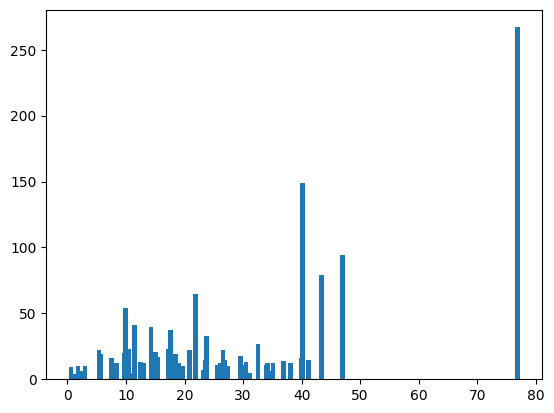

In [25]:
top_comments_df['rank'] = .5 * top_comments_df.rounds + .5 * top_comments_df.balance
plt.bar(top_comments_df['rank'] * 100, top_comments_df.replies)

Not too bad. Now we can show the top 5 debating threads as a tree for easy reading:

In [40]:
def render(xml):
  from IPython.display import HTML
  template = """
  <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/js/bootstrap.min.js"></script>
  <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/css/bootstrap.min.css">
  %s"""
  return HTML(template % xml)

output = '<ul>'
for id,top_comment in top_comments_df.sort_values(['rank'], ascending=False).head(20).iterrows():
  output += f'<li>{top_comment.text} (<i>{top_comment.author}</i> @ {top_comment.publishedAt})'
  output += f'<button class="btn btn-primary" data-bs-toggle="collapse" data-bs-target="#thread-{id}"> + </button></li>'
  output += f'<ul class="collapse" id="thread-{id}">'
  for idx, reply in replies_df[replies_df.parent == id].iterrows():
    output += f'<li>({reply.stance and "👍" or"👎"}):{reply.reply_text} (<i>{reply.author}</i>)</li>'
  output += '</ul>'
output += '</ul>'
render(output)
